<a href="https://colab.research.google.com/github/Ni7070/EkusheDatasetMaleFemaleHandwritingRecognizer/blob/main/Ekushe_Dataset_Male_Female_Handwriting_Recognizer_with_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import os
from os import path
import shutil
import glob

In [ ]:
#HYPERPERAMETERS
batch_size = 100
num_iters = 5000
input_dim = 28*28 # num_features = 784
output_dim = 2

learning_rate = 0.005

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#taking csv files
female_digit = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ekushCSV/Female/femaleDigits.csv")
male_digit = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ekushCSV/Male/maleDigits.csv")

In [ ]:
#changing the label colums value for female 1, male 0
female_digit['label'] = 1
male_digit['label'] = 0

In [ ]:
#concating all labels 
female_label = female_digit['label']

male_label = male_digit['label']

labels = pd.concat([female_label, male_label],ignore_index=True)

In [ ]:
#concating all images
images = pd.concat([female_digit, male_digit],ignore_index=True)
images = images.drop(labels='label',axis=1)
print(images.shape)
print(images)
print(labels)
print(labels.shape)

In [ ]:
#normalizing and reshaping images
images = images/255.0
images = images.values.reshape(-1,28,28,1)

0
male writing


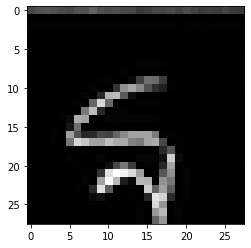

In [ ]:
#plotting a digit
import matplotlib.pyplot as plt 
import numpy as np

i = 30820
show_img = images[i].reshape(28, 28)
plt.imshow(show_img, cmap='gray')
print(labels[i])
if(labels[i]==1):
  print("female writing")
else:
  print("male writing")


In [ ]:
#split data into train:test = 90:10
from sklearn.model_selection import train_test_split
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.1)
print(image_test)

In [ ]:
#creating dataset
train_dataset = list(zip(image_train, label_train))
test_dataset = list(zip(image_test, label_test))

In [ ]:
'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

#using pytorch dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.sigmoid(logits)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

###Train 1#: Training: forward, loss, backward, step for batch =32, num_of_iter = 4000, learning rate 0.001

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.6719418168067932. Accuracy: 55.27084009082063
Iteration: 1000. Loss: 0.6855542063713074. Accuracy: 57.44404800518975
Iteration: 1500. Loss: 0.6963982582092285. Accuracy: 57.606227700291925
Iteration: 2000. Loss: 0.6391500234603882. Accuracy: 58.027894907557574
Iteration: 2500. Loss: 0.6634421348571777. Accuracy: 58.64417774894583
Iteration: 3000. Loss: 0.6967478394508362. Accuracy: 58.384690236782355


[0.6719418168067932, 0.6855542063713074, 0.6963982582092285, 0.6391500234603882, 0.6634421348571777, 0.6967478394508362]


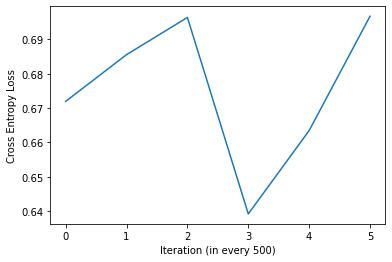

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

###Train 2#: Training: forward, loss, backward, step for batch =50, num_of_iter = 4000, learning rate 0.001

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.7193924784660339. Accuracy: 49.10801167693805
Iteration: 1000. Loss: 0.7268189191818237. Accuracy: 49.10801167693805
Iteration: 1500. Loss: 0.7104661464691162. Accuracy: 49.10801167693805
Iteration: 2000. Loss: 0.7045239806175232. Accuracy: 49.10801167693805
Iteration: 2500. Loss: 0.6911159753799438. Accuracy: 49.10801167693805
Iteration: 3000. Loss: 0.7310390472412109. Accuracy: 49.10801167693805
Iteration: 3500. Loss: 0.7075114250183105. Accuracy: 49.10801167693805


[0.739123523235321, 0.6843844652175903, 0.7447174191474915, 0.6825746893882751, 0.7113325595855713, 0.7411127686500549, 0.7165728807449341]


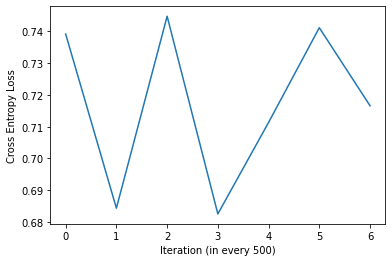

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

###Train 3#: Training: forward, loss, backward, step for batch =80, num_of_iter = 4000, learning rate 0.001

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.6757668256759644. Accuracy: 55.2384041518002
Iteration: 1000. Loss: 0.699467658996582. Accuracy: 57.41161206616932
Iteration: 1500. Loss: 0.6811739206314087. Accuracy: 56.95750891988323
Iteration: 2000. Loss: 0.6570854187011719. Accuracy: 58.319818358741486
Iteration: 2500. Loss: 0.6848873496055603. Accuracy: 58.44956211482322
Iteration: 3000. Loss: 0.6619780659675598. Accuracy: 58.64417774894583
Iteration: 3500. Loss: 0.645311713218689. Accuracy: 58.77392150502757


[0.6757668256759644, 0.699467658996582, 0.6811739206314087, 0.6570854187011719, 0.6848873496055603, 0.6619780659675598, 0.645311713218689]


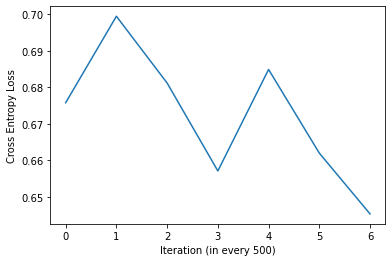

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

###Train 4#: Training: forward, loss, backward, step for batch = 80, num_of_iter = 3000, learning rate 0.001

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.6898146271705627. Accuracy: 51.83263055465456
Iteration: 1000. Loss: 0.6952906847000122. Accuracy: 55.2384041518002
Iteration: 1500. Loss: 0.691831648349762. Accuracy: 56.73045734674019
Iteration: 2000. Loss: 0.6997753977775574. Accuracy: 57.216996432046706
Iteration: 2500. Loss: 0.668441891670227. Accuracy: 57.80084333441453
Iteration: 3000. Loss: 0.6803122758865356. Accuracy: 58.12520272461888
Iteration: 3500. Loss: 0.6565977334976196. Accuracy: 57.83327927343497
Iteration: 4000. Loss: 0.6816076040267944. Accuracy: 58.28738241972105
Iteration: 4500. Loss: 0.679470419883728. Accuracy: 58.35225429776192


[0.6898146271705627, 0.6952906847000122, 0.691831648349762, 0.6997753977775574, 0.668441891670227, 0.6803122758865356, 0.6565977334976196, 0.6816076040267944, 0.679470419883728]


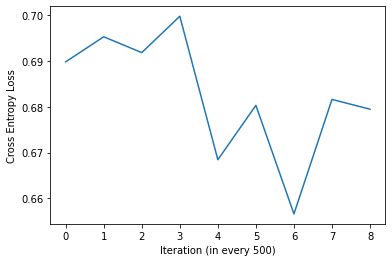

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

###Train 5#: Training: forward, loss, backward, step for batch = 100, num_of_iter = 4000, learning rate 0.01

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.6401136517524719. Accuracy: 58.93610120012974
Iteration: 1000. Loss: 0.6400499939918518. Accuracy: 59.065844956211485
Iteration: 1500. Loss: 0.6512302160263062. Accuracy: 58.25494648070062
Iteration: 2000. Loss: 0.6618243455886841. Accuracy: 58.09276678559844
Iteration: 2500. Loss: 0.6614637970924377. Accuracy: 59.29289652935452
Iteration: 3000. Loss: 0.6633780598640442. Accuracy: 58.6117418099254
Iteration: 3500. Loss: 0.6786178350448608. Accuracy: 58.806357444048004


[0.6401136517524719, 0.6400499939918518, 0.6512302160263062, 0.6618243455886841, 0.6614637970924377, 0.6633780598640442, 0.6786178350448608]


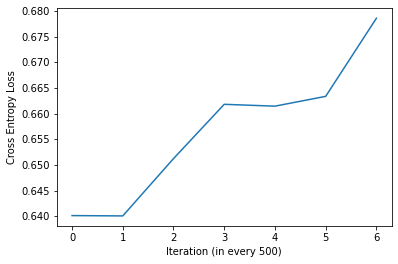

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

###Train 6#: Training: forward, loss, backward, step for batch = 100, num_of_iter = 5000, learning rate 0.005

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.6706626415252686. Accuracy: 58.51443399286409
Iteration: 1000. Loss: 0.6880522966384888. Accuracy: 59.26046059033409
Iteration: 1500. Loss: 0.7010437250137329. Accuracy: 59.39020434641583
Iteration: 2000. Loss: 0.6607619524002075. Accuracy: 58.64417774894583
Iteration: 2500. Loss: 0.6753867864608765. Accuracy: 59.22802465131365
Iteration: 3000. Loss: 0.6616194248199463. Accuracy: 59.098280895231916
Iteration: 3500. Loss: 0.6608920097351074. Accuracy: 58.48199805384366
Iteration: 4000. Loss: 0.6451835036277771. Accuracy: 59.19558871229322
Iteration: 4500. Loss: 0.6356450915336609. Accuracy: 58.709049626986705
Iteration: 5000. Loss: 0.6553906202316284. Accuracy: 59.3577684073954


[0.6706626415252686, 0.6880522966384888, 0.7010437250137329, 0.6607619524002075, 0.6753867864608765, 0.6616194248199463, 0.6608920097351074, 0.6451835036277771, 0.6356450915336609, 0.6553906202316284]


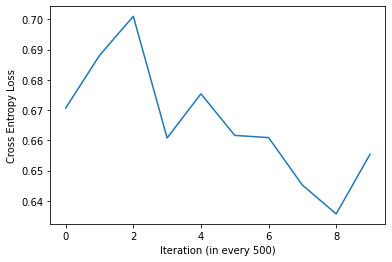

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

###Train 7#: Training: forward, loss, backward, step for batch = 100, num_of_iter = 5000, learning rate 0.005 for Adam optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.7241024971008301. Accuracy: 57.83327927343497
Iteration: 1000. Loss: 0.7308651208877563. Accuracy: 57.50891988323062
Iteration: 1500. Loss: 0.7707011699676514. Accuracy: 54.84917288355498
Iteration: 2000. Loss: 0.6718245148658752. Accuracy: 57.281868310087575
Iteration: 2500. Loss: 0.6876416802406311. Accuracy: 56.925072980862794
Iteration: 3000. Loss: 0.654747724533081. Accuracy: 55.20596821277976
Iteration: 3500. Loss: 0.5885314345359802. Accuracy: 55.98443074927019
Iteration: 4000. Loss: 0.6792622208595276. Accuracy: 57.11968861498541
Iteration: 4500. Loss: 0.5892549753189087. Accuracy: 57.89815115147584
Iteration: 5000. Loss: 0.6062642931938171. Accuracy: 58.15763866363931


[0.7241024971008301, 0.7308651208877563, 0.7707011699676514, 0.6718245148658752, 0.6876416802406311, 0.654747724533081, 0.5885314345359802, 0.6792622208595276, 0.5892549753189087, 0.6062642931938171]


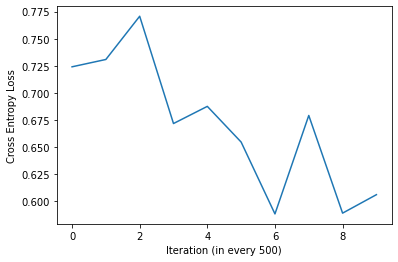

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

###Train 8#: Training: forward, loss, backward, step for batch = 100, num_of_iter = 5000, learning rate 0.005 for Adadelta optimizer

In [ ]:
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.6758179664611816. Accuracy: 58.44956211482322
Iteration: 1000. Loss: 0.6460205316543579. Accuracy: 58.319818358741486
Iteration: 1500. Loss: 0.6129244565963745. Accuracy: 58.28738241972105
Iteration: 2000. Loss: 0.6773240566253662. Accuracy: 58.027894907557574
Iteration: 2500. Loss: 0.6269770264625549. Accuracy: 58.28738241972105
Iteration: 3000. Loss: 0.6758952140808105. Accuracy: 58.19007460265975
Iteration: 3500. Loss: 0.7007902264595032. Accuracy: 58.64417774894583
Iteration: 4000. Loss: 0.6596431732177734. Accuracy: 58.51443399286409
Iteration: 4500. Loss: 0.6431525945663452. Accuracy: 58.64417774894583
Iteration: 5000. Loss: 0.6463912129402161. Accuracy: 58.67661368796627


[0.6758179664611816, 0.6460205316543579, 0.6129244565963745, 0.6773240566253662, 0.6269770264625549, 0.6758952140808105, 0.7007902264595032, 0.6596431732177734, 0.6431525945663452, 0.6463912129402161]


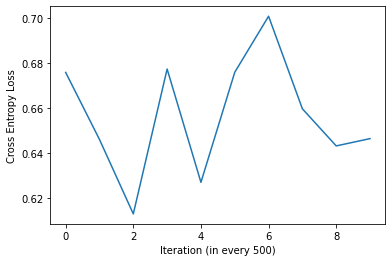

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

Train 9#: Training: forward, loss, backward, step for batch = 100, num_of_iter = 5000, learning rate 0.005 for Adagrad optimizer

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, lr_decay=0)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.6770710945129395. Accuracy: 58.09276678559844
Iteration: 1000. Loss: 0.6296424269676208. Accuracy: 57.606227700291925
Iteration: 1500. Loss: 0.652589738368988. Accuracy: 57.184560493026275
Iteration: 2000. Loss: 0.657683789730072. Accuracy: 58.22251054168018
Iteration: 2500. Loss: 0.6602136492729187. Accuracy: 57.67109957833279
Iteration: 3000. Loss: 0.6817768812179565. Accuracy: 57.606227700291925
Iteration: 3500. Loss: 0.6395620107650757. Accuracy: 57.7684073953941
Iteration: 4000. Loss: 0.6403299570083618. Accuracy: 57.8657152124554
Iteration: 4500. Loss: 0.6326785683631897. Accuracy: 57.37917612714888
Iteration: 5000. Loss: 0.6190881133079529. Accuracy: 57.50891988323062


[0.6770710945129395, 0.6296424269676208, 0.652589738368988, 0.657683789730072, 0.6602136492729187, 0.6817768812179565, 0.6395620107650757, 0.6403299570083618, 0.6326785683631897, 0.6190881133079529]


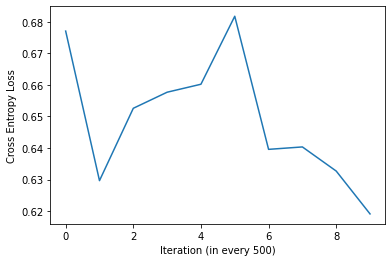

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

Train 10#: Training: forward, loss, backward, step for batch = 100, num_of_iter = 5000, learning rate 0.005 for RMSprop optimizer

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.9018403887748718. Accuracy: 56.56827765163801
Iteration: 1000. Loss: 0.8016624450683594. Accuracy: 55.75737917612715
Iteration: 1500. Loss: 0.6743634939193726. Accuracy: 52.286733700940644
Iteration: 2000. Loss: 0.719412088394165. Accuracy: 57.216996432046706
Iteration: 2500. Loss: 0.6103846430778503. Accuracy: 55.88712293220889
Iteration: 3000. Loss: 0.7272274494171143. Accuracy: 52.02724618877716
Iteration: 3500. Loss: 0.6877433061599731. Accuracy: 53.45442750567629
Iteration: 4000. Loss: 0.8457466959953308. Accuracy: 50.98929614012326
Iteration: 4500. Loss: 0.7156524658203125. Accuracy: 57.37917612714888
Iteration: 5000. Loss: 0.6988064050674438. Accuracy: 56.60071359065845


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

Train 11#: Training: forward, loss, backward, step for batch = 100, num_of_iter = 5000, learning rate 0.01 for SGD optimizer with momentum

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 500. Loss: 0.671078622341156. Accuracy: 57.541355822251056
Iteration: 1000. Loss: 0.6507434248924255. Accuracy: 56.79532922478106
Iteration: 1500. Loss: 0.6420186758041382. Accuracy: 58.44956211482322
Iteration: 2000. Loss: 0.7013269662857056. Accuracy: 57.249432371067144
Iteration: 2500. Loss: 0.6826412081718445. Accuracy: 57.184560493026275
Iteration: 3000. Loss: 0.6352545022964478. Accuracy: 57.15212455400584
Iteration: 3500. Loss: 0.6686646342277527. Accuracy: 57.15212455400584
Iteration: 4000. Loss: 0.6972860097885132. Accuracy: 57.41161206616932
Iteration: 4500. Loss: 0.6334566473960876. Accuracy: 57.73597145637366
Iteration: 5000. Loss: 0.6705312132835388. Accuracy: 58.41712617580279


[0.671078622341156, 0.6507434248924255, 0.6420186758041382, 0.7013269662857056, 0.6826412081718445, 0.6352545022964478, 0.6686646342277527, 0.6972860097885132, 0.6334566473960876, 0.6705312132835388]


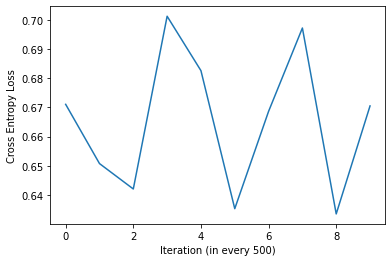

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

Train 12#: Training: forward, loss, backward, step for batch = 100, num_of_iter = 5000, learning rate 0.0105 for SGD optimizer with momentum

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_dim,
                                num_classes=output_dim)
# To enable GPU
model.to(device)


LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images.float()) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6612120866775513. Accuracy: 58.87122932208887
Iteration: 1000. Loss: 0.6893187761306763. Accuracy: 58.25494648070062
Iteration: 1500. Loss: 0.6731951236724854. Accuracy: 58.48199805384366
Iteration: 2000. Loss: 0.6617110967636108. Accuracy: 59.3577684073954
Iteration: 2500. Loss: 0.6414650678634644. Accuracy: 59.3577684073954
Iteration: 3000. Loss: 0.6536688208580017. Accuracy: 59.61725591955887
Iteration: 3500. Loss: 0.6452279090881348. Accuracy: 59.584819980538434
Iteration: 4000. Loss: 0.6284884810447693. Accuracy: 59.941615309763215
Iteration: 4500. Loss: 0.6821850538253784. Accuracy: 59.098280895231916
Iteration: 5000. Loss: 0.6601450443267822. Accuracy: 59.487512163477135


[0.6612120866775513, 0.6893187761306763, 0.6731951236724854, 0.6617110967636108, 0.6414650678634644, 0.6536688208580017, 0.6452279090881348, 0.6284884810447693, 0.6821850538253784, 0.6601450443267822]


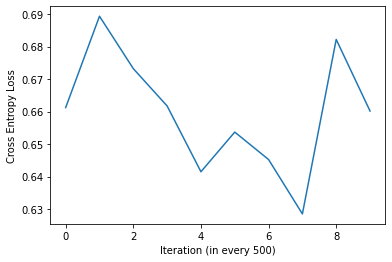

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# **Assignment #2**#
 **ID:16.02.04.070**
- **1st Settings:**
First I have tried with smaller batch size of 32 and went with a 0.001 learning rate and iterated them with 4000 times. I will later increase the batch size and learning rate little by little to see if the model does better.Used the SGD optimizer and as this is a binary classification problem, used sigmoid activation function.
- **2nd Settings:**
Started increasing the batch size from 32 to 50.Accuracy got somewhat decreased.
- **3rd Settings:**
Started increasing the batch size from 50 to 80.Accuracy got somewhat increased.Crossentropy loss decreased.
- **4th Settings:**
Increased the number of interation to 5000. Accuracy didn't change much but the cross entropy loss graph looked bad.
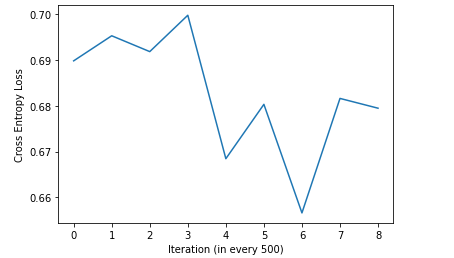
- **5th Settings:**
Increased the batch size to 100 and learning rate to 0.01. Accuracy hit 58.8% but the model seemed to be overfed.
- **6th Settings:**
decreadsed the learning rate to 0.005. Accuracy didn't change much.

All there time, the accuracy was like 58.7% to 59.3%, so I tried to bring changes in the optimizer to see what happens.
- **7th Settings:**

changed to the Adam optimizer.Accuracy was slightly lower than the SGD optimizer.
- **8th Settings:**

changed to the Adadelta optimizer.Accuracy was slightly better than the Adam optimizer.
- **9th Settings:**

changed to the Adagrad optimizer.It is a gradiant decent one. Accuracy was lower than other optimizers.
- **10th Settings:**

changed to the RMSprop optimizer. Accuracy was much lower than other optimizers.
- **11th Settings:**
Tried the SGD optimiger with momentum. It gave better accuracy than the recent optimizers.

- **12th Settings:**
Softmax is a generalization of te sigmoid function, for binary classes, softmax is the same as sigmoid. So, i tried to implement softmax for binary classification. Softmax with SGD gave almost identical result with Sigmoid with SGD.



No.|batch_size | num_iters | learning rate|accuracy|optimizer|activation function|
---|---|---|---|---|---|---|
1|32|4000|0.001|58.709049626986705%|SGD|sigmoid|
2|50|4000|0.001|49.10801167693805%|SGD|sigmoid|
3|80|4000|0.001|58.77392150502757%|SGD|sigmoid|
4|80|5000|0.001|58.35225429776192%|SGD|sigmoid|
5|100|4000|0.01|58.806357444048004%|SGD|sigmoid|
6|100|5000|0.005|59.3577684073954%|SGD|sigmoid|
7|100|5000|0.005|58.15763866363931%|Adam|sigmoid|
8|100|5000|0.005|58.67661368796627%|Adadelta|sigmoid|
9|100|5000|0.005|57.50891988323062%|Adagrad|sigmoid|
10|100|5000|0.005|56.60071359065845%|RMSprop|sigmoid|
11|100|5000|0.01|58.41712617580279%|SGD(momentum)|sigmoid|
12|100|5000|0.005|59.487512163477135%|SGD|softmax|

In [ ]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/pickle Files'

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'ekushe_logisticR12.pkl') 

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'ekushe_logisticR12.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded
